# Example — Structural bar network using the diffusive network architecture

This example reformulates a **1D linear elastic bar structure** as a **diffusive network problem**, following exactly the same steps used in the hydraulic tutorial.

The example is adapted from:

* Moaveni, S. (2011). *Finite Element Analysis: Theory and Application with ANSYS*, Example 1.1.

* <img src="images/barra1.svg" width="400">

---

## 1. Physical problem description

We consider a system of **axially loaded bars** connected in series:

* A force $P = 1000  \mathrm{lb}$ is applied at the free end
* The left end is fixed: $u_0 = 0$
* $l = 10 , \mathrm{in}$ (all bars)
* The material is linear elastic with:

$$
E = 10.4 \times 10^6  \mathrm{lb/in^2}
$$

* Each bar has a different cross-sectional area $A_i$

---

## 2. Governing equations (structural mechanics)

### 2.1 Stress–strain–displacement relations

The average axial stress in a bar is:

$$
\sigma = \frac{F}{A}
$$

The axial strain is defined as:

$$
\epsilon = \frac{\Delta l}{l}
$$

For a linear elastic material:

$$
\sigma = E \epsilon
$$

Combining these expressions gives the **force–displacement relation**:

$$
F = \frac{AE}{l}  \Delta l
$$

We define the **element stiffness**:

$$
k = \frac{AE}{l}
$$

---

## 3. Network interpretation (key idea)

At this point, the analogy with the **fluid diffusive network** becomes clear:

| Structural problem | Diffusive network     |
| ------------------ | --------------------- |
| Displacement $u$   | Hydraulic head $H$    |
| Force $F$          | Nodal flow $b$        |
| Bar                | Pipe                  |
| Stiffness $k$      | Hydraulic conductance |
| Force balance      | Flow conservation     |

The governing equation has the same structure:

$$
F = k  \Delta u
$$

which is formally identical to:

$$
Q = k  \Delta H
$$

---

## 4. Network definition (same architecture as fluid tutorial)

We now follow **exactly the same steps** as in the fluid example.

### 4.1 Create the network

```python
net = Network()
```

---

### 4.2 Define connectivity

Each bar connects two nodes:


In [1]:
import numpy as np
import netsystems as ns

In [2]:
net = ns.Network()

connectivity = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
])

net.set_connectivity(connectivity)

This defines a **1D bar chain**, identical in spirit to a pipe network.

---

## 5. Structural system as a diffusive system

We model the structure as a **diffusive system**, where:

* Unknown nodal variable: displacement
* Nodal source term: applied force
* Edge variable: internal axial force

In [3]:
solid = ns.System("solid", system_type="diffusive")

solid.x_name = "nodal_displacement"
solid.b_name = "nodal_force"
solid.element_variable_name = "axial_force"

## 6. Boundary conditions

### 6.1 Prescribed displacements (Dirichlet)

The left end is fixed:

$$
u_0 = 0
$$

In [4]:
solid.known_x_nodes = np.array([0])
solid.known_x_values = np.array([0.0])


### 6.2 Applied forces (Neumann)

A force is applied at the last node:

$$
F_4 = 1000  \mathrm{lb}
$$


In [5]:
solid.known_b_nodes = np.array([4])
solid.known_b_values = np.array([1000.0])

## 7. Element stiffness (key equivalence)

### 7.1 Structural stiffness formula

For each bar $i$:

$$
k_i = \frac{A_i E}{l_i}
$$

This plays **exactly the same role** as hydraulic conductance in the fluid problem.

---

### 7.2 Code implementation

In [6]:
A = np.array([0.234375, 0.203125, 0.171875, 0.140625])
l = np.ones(net.n_elements) * 2.5
E = np.ones(net.n_elements) * 10.4e6

solid.element_conductance = A * E / l

Here:

* `element_property[i]` = stiffness of bar $i$
* This value multiplies the displacement difference between the connected nodes

---

## 8. Assembly and solution

### 8.1 Add system to the network

In [7]:
net.add_system(solid)

### 8.2 Solve the linear system


In [8]:
ns.solve_linear_system(net, "solid")

0

Internally, this performs:

1. Element matrix assembly
2. Global stiffness matrix construction
3. Application of boundary conditions
4. Linear system solution

## 9. Extracting results (same interface as fluid)

### 9.1 Nodal displacements

In [9]:
net.get("nodal_displacement")

array([0.        , 0.00102564, 0.00220907, 0.00360767, 0.00531708])

In [10]:
net.get("nodal_force")

array([-1000.,     0.,     0.,     0.,  1000.])


## Global stiffness matrix inspection

### Obtain global matrix

In [11]:
K = ns.get_global_matrix_csr(net, "solid")
print(K.todense())

[[ 975000. -975000.       0.       0.       0.]
 [-975000. 1820000. -845000.       0.       0.]
 [      0. -845000. 1560000. -715000.       0.]
 [      0.       0. -715000. 1300000. -585000.]
 [      0.       0.       0. -585000.  585000.]]



This matrix is:

* Symmetric
* Positive definite
* Identical in structure to the stiffness matrix in FEM textbooks

---

### Sparsity visualization

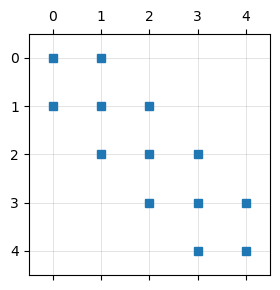

(<Figure size 300x300 with 1 Axes>, <Axes: >)

In [12]:
ns.spy_matrix(K, title=None, markersize=6, figsize=(3, 3))